# Setup

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../../'  # this file should be run from {caffe_root}/models/bvlc_alexnet_FCN_wTOPO/ (otherwise change this line)
sys.path.insert(0, caffe_root + "python/")

import caffe


#### 2. Load net and set up input preprocessing

In [10]:
model_def = caffe_root + 'models/bvlc_alexnet_FCN_wTOPO/my_alexnet_fcn.prototxt'
model_weights = caffe_root + 'models/bvlc_alexnet_FCN_wTOPO/alexnet_LT.caffemodel'
# model_weights = caffe_root + 'train_alexnet_Topo_pretrained_iter_18000.caffemodel'


net = caffe.Net(model_def,      # defines the structure of the model
                model_weights)     # use test mode (e.g., don't perform dropout)


In [11]:
net.set_phase_test()
net.set_device(0)
net.set_mode_gpu()

In [9]:
net.copy_from(model_weights)

## Prepare the data

In [12]:
root_dataset = caffe_root + "data/Warwick/"

In [13]:
train_file_name = caffe_root + "data/Warwick/test_files.txt"

with open(train_file_name) as f:
    lines = f.readlines()
    data_sample = np.zeros((len(lines), 3, 500,500))
    labels_data = np.zeros((len(lines), 1, 500, 500), dtype=np.uint8)
    cpt = 0
    for line in lines:
        line = line.split(' ')
        train_img_name = line[0]
        train_labelimg_name = line[1][:-1] #-1 because of the \n
        
        train_img = caffe.io.load_image(root_dataset + train_img_name)
        train_labelimg = caffe.io.load_image(root_dataset + train_labelimg_name, color=False)
        train_img = caffe.io.resize_image(train_img, (500,500), interp_order=1)
        
        train_img = np.array(train_img, dtype=np.float32)
#         max_img, min_img = np.max(train_img), np.min(train_img)
#         train_img = 2*(train_img-max_img)/(max_img - min_img) - 1
#         train_img = train_img[:,:,::-1]
#         train_img -= self.mean
        data_sample[cpt, : ,:, :] = train_img.transpose((2,0,1))
        
        
        train_labelimg = caffe.io.resize_image(train_labelimg, (500,500), interp_order=0)
#         data_sample[cpt, : ,:, :] = train_img.reshape((3,500,500))
        labels_data[cpt, :, :, :] = train_labelimg.transpose(2,0,1)*255
        
        cpt += 1
        
# mean_image = np.mean(data_sample, axis=0)
# data_sample[:] -= mean_image

# data_samples = np.zeros(())

In [47]:
np.unique(labels_data)

array([0, 1, 2], dtype=uint8)

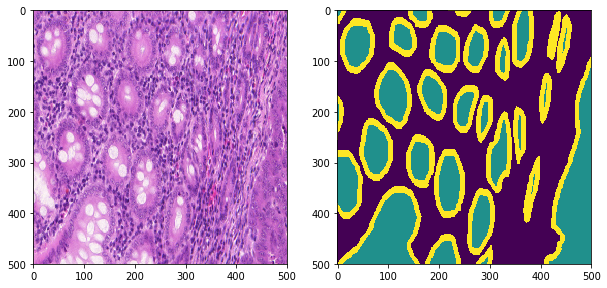

In [76]:
##### plt.figure()
plt.subplot(1,2,1)
# plt.imshow((data_sample[0,:,:,:]+mean_image).transpose(1,2,0)[:,:,::-1])
plt.imshow((data_sample[0,:,:,:]).transpose(1,2,0))
plt.subplot(1,2,2)
plt.imshow(labels_data[0,:,:,:].reshape((500,500)))

## Do the training

In [153]:
net.set_device(0)
net.set_mode_gpu()

In [ ]:
solver_name = caffe_root + "models/bvlc_alexnet_FCN_wTOPO/solver_alexnet_fcn.prototxt"
solver = caffe.SGDSolver(solver_name)
caffe.SGDSolver.net

In [ ]:
solver.solve()

## TEST

In [36]:
labels_data.shape

(80, 1, 500, 500)

In [14]:
# net.set_phase_test()
num_image_test = 2
image_test = data_sample[num_image_test, :,:,:]
image_label = labels_data[num_image_test, :,:,:]

net.blobs['data'].data[...] = image_test

net.forward()
net.blobs["score-final"].data[0,:,:,:]

ValueError: could not broadcast input array from shape (3,500,500) into shape (1,3,256,216)

In [124]:
out = net.blobs["score-final"].data[0,:,:,:]

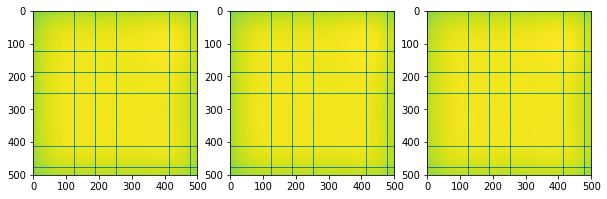

In [131]:
plt.subplot(1,3,1)
plt.imshow(out[0,:,:])
plt.subplot(1,3,2)
plt.imshow(out[1,:,:])
plt.subplot(1,3,3)
plt.imshow(out[2,:,:])

In [91]:
image_out = net.blobs["score-final"].data[0,:,:,:].argmax(axis=0)
image_out

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [92]:
np.sum(image_out)

0

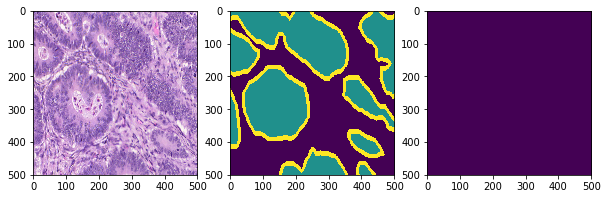

In [93]:
plt.subplot(1,3,1)
plt.imshow(image_test.transpose(1,2,0))
plt.subplot(1,3,2)
image_truelabel = image_label.reshape((500,500))
plt.imshow(image_truelabel)
plt.subplot(1,3,3)
plt.imshow(image_out)

In [116]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 500, 500)
data_input_0_split_0	(1, 3, 500, 500)
data_input_0_split_1	(1, 3, 500, 500)
conv1	(1, 96, 173, 173)
pool1	(1, 96, 86, 86)
norm1	(1, 96, 86, 86)
conv2	(1, 256, 86, 86)
pool2	(1, 256, 43, 43)
norm2	(1, 256, 43, 43)
conv3	(1, 384, 45, 45)
conv4	(1, 384, 45, 45)
conv5	(1, 256, 45, 45)
pool5	(1, 256, 22, 22)
fc6	(1, 4096, 17, 17)
fc7	(1, 4096, 17, 17)
score	(1, 3, 17, 17)
score-big	(1, 3, 575, 575)
score-final	(1, 3, 500, 500)


# Display conv values

In [41]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

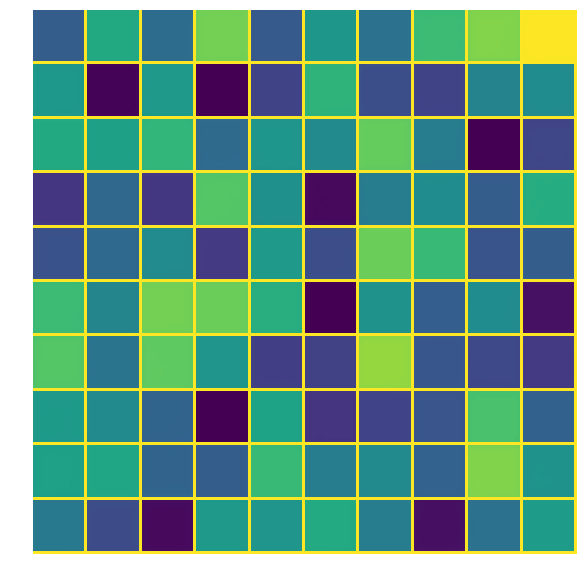

In [66]:
feat = net.blobs['fc7'].data[0, :100]
vis_square(feat)

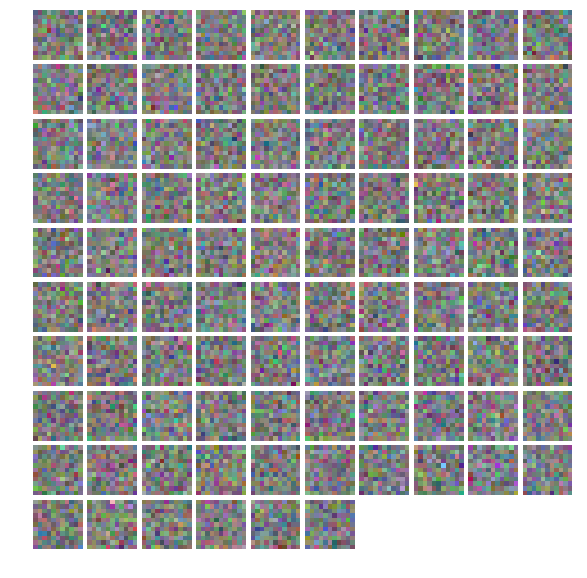

In [101]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

In [120]:
net.params['upsample-big'][0].data

array([[[[ 0.00024414,  0.00073242,  0.0012207 , ...,  0.00170898,
           0.0012207 ,  0.00073242],
         [ 0.00073242,  0.00219727,  0.00366211, ...,  0.00512695,
           0.00366211,  0.00219727],
         [ 0.0012207 ,  0.00366211,  0.00610352, ...,  0.00854492,
           0.00610352,  0.00366211],
         ..., 
         [ 0.00170898,  0.00512695,  0.00854492, ...,  0.01196289,
           0.00854492,  0.00512695],
         [ 0.0012207 ,  0.00366211,  0.00610352, ...,  0.00854492,
           0.00610352,  0.00366211],
         [ 0.00073242,  0.00219727,  0.00366211, ...,  0.00512695,
           0.00366211,  0.00219727]]],


       [[[ 0.00024414,  0.00073242,  0.0012207 , ...,  0.00170898,
           0.0012207 ,  0.00073242],
         [ 0.00073242,  0.00219727,  0.00366211, ...,  0.00512695,
           0.00366211,  0.00219727],
         [ 0.0012207 ,  0.00366211,  0.00610352, ...,  0.00854492,
           0.00610352,  0.00366211],
         ..., 
         [ 0.00170898,  0.0051

In [102]:
filters.transpose(0, 2, 3, 1).shape

(96, 11, 11, 3)